# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### Follow These Instructions

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.



#### In this assignment, we will work on the bank loan data. The task is to build a model given the information of clients to predict whether the clients default or not. The data file is `loan_Data.csv`.  The target variable is `loanDefault`, which can be Fully Paid or Charged Off. The data includes some information about the payment behavior and customer characteristics such as job and purpose acquiring the current loan. You could view the description of the variables in `loan_param.xlsx`.



---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score


pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.style.use('ggplot')

_____

## Question 1: /10 pts

#### 1.1 Load the data `loan_Data.csv` and display the last 10 rows. How many features and how many obersvations are there in the dataset?

In [2]:
# Load the data
data = pd.read_csv('loan_Data.csv', sep=';')
data.tail(10)
# 2 pt

,loanAmnt,annualInc,application_type,int_rate,revol_bal,revol_util,dti,emp_length,grade,homeOwnership,installment,job,loanDefault,mortAcc,pub_rec_bankruptcies,purpose,term,Year
990,3900.0,38100.0,INDIVIDUAL,7.90,10936.0,91.9,15.06,6,A,MORTGAGE,122.04,University of North Carolina,Fully Paid,6,0,credit_card,36,2011
991,12000.0,70000.0,INDIVIDUAL,6.62,22219.0,60.1,28.58,10,A,MORTGAGE,368.45,school dist. 21,Fully Paid,12,0,debt_consolidation,36,2012
992,3125.0,70000.0,INDIVIDUAL,11.44,2875.0,58.0,2.64,10,B,MORTGAGE,102.97,Carrier,Fully Paid,5,1,credit_card,36,2015
993,30375.0,150000.0,INDIVIDUAL,14.31,55242.0,70.8,24.79,1,C,RENT,1042.73,Vice President,Fully Paid,11,0,debt_consolidation,36,2015
994,35000.0,135000.0,INDIVIDUAL,11.99,30620.0,56.0,18.80,1,C,MORTGAGE,778.38,Registered Nurse,Fully Paid,19,0,debt_consolidation,60,2015
995,10000.0,40000.0,INDIVIDUAL,17.86,9023.0,52.5,26.07,5,D,MORTGAGE,253.18,property manager,Charged Off,11,0,credit_card,60,2015
996,9000.0,96000.0,INDIVIDUAL,6.49,17017.0,30.4,8.91,1,A,RENT,275.81,Communications Manager,Fully Paid,16,0,credit_card,36,2014
997,5600.0,65000.0,INDIVIDUAL,8.90,21409.0,92.7,12.09,4,A,MORTGAGE,177.82,Grasmere Place,Fully Paid,11,0,vacation,36,2012
998,25000.0,79980.0,INDIVIDUAL,19.72,9706.0,69.8,17.73,2,D,RENT,658.46,bed bath & beyond,Fully Paid,9,0,debt_consolidation,60,2012
999,15000.0,63000.0,INDIVIDUAL,11.99,15493.0,69.5,17.57,2,B,RENT,498.15,Account Manager,Fully Paid,28,0,credit_card,36,2014


In [3]:
data.shape # any method can be used

(1000, 18)

**Written Answer** [2 pt]: 1000 observations and 17 features



#### 1.2 Create a bar graph to visualize the count of `Charged Off` and `Fully Paid`. Calculate the percentage of `Charged off`, which is the percentage of default.

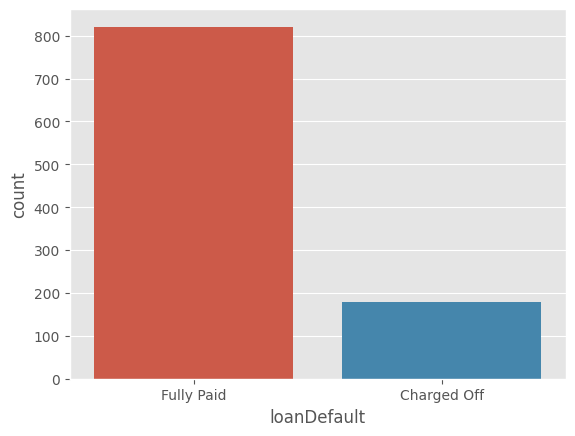

In [4]:
# Plot
sns.countplot(x='loanDefault', data = data)
plt.show()
# 2pts

In [5]:
# Calculate the percentage
pct = sum(data.loanDefault == "Charged Off") / data.shape[0]
print("The percentage of default is {}".format(pct))

The percentage of default is 0.179


**Written Answer** [2 pt]: What is the percentage of defaulters? 17.9%

#### 1.3 Change the values of the column `loanDefault` to 1 if the loan is `Charged Off` and 0 if it is `Fully Paid`.

In [6]:
# Change the values
data['loanDefault']=(data.loanDefault=='Charged Off')*1
data.head()

# 2 pts

,loanAmnt,annualInc,application_type,int_rate,revol_bal,revol_util,dti,emp_length,grade,homeOwnership,installment,job,loanDefault,mortAcc,pub_rec_bankruptcies,purpose,term,Year
0,10000.0,117000.0,INDIVIDUAL,11.44,36369.0,41.8,26.24,10,B,RENT,329.48,Marketing,0,16,0,vacation,36,2015
1,8000.0,65000.0,INDIVIDUAL,11.99,20131.0,53.3,22.05,4,B,MORTGAGE,265.68,Credit analyst,0,17,0,debt_consolidation,36,2015
2,15600.0,43057.0,INDIVIDUAL,10.49,11987.0,92.2,12.79,1,B,RENT,506.97,Statistician,0,13,0,credit_card,36,2015
3,7200.0,54000.0,INDIVIDUAL,6.49,5472.0,21.5,2.60,6,A,RENT,220.65,Client Advocate,0,6,0,credit_card,36,2014
4,24375.0,55000.0,INDIVIDUAL,17.27,24584.0,69.8,33.95,9,C,MORTGAGE,609.33,Destiny Management Inc.,1,13,0,credit_card,60,2013


_____________

## Question 2: /16 pts
Here we are interested in if the distribution of income is different between clients who defaulted and those who did not default on their loans.

#### 2.1 First create the histogram of the annual income `annualInc` for all the clients. Do not forget to label the axes.

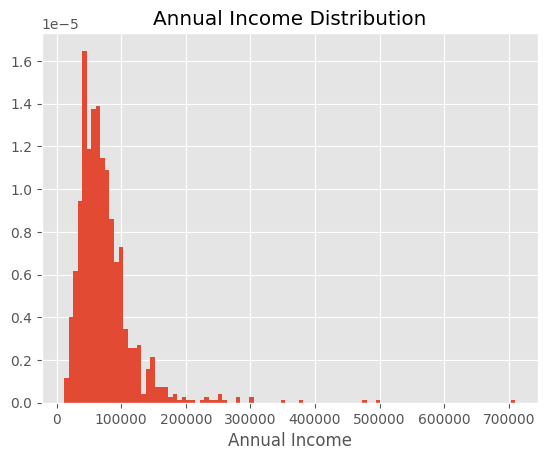

In [7]:
# Plot the distribution
data.annualInc.hist(bins=100, density=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")
plt.show()
# 2 pts

What do you notice about the distribution of the annual income variable? What transformation would you suggest for it?

**Witten Answer**[2 pts]: The distribution is right-skewed and has a heavy tail. Therefore it is better to transform it by applying the logarithm function.


#### 2.2  Apply the transformation (*i.e.*, based on your answer to the previous question) to annual income and plot the histogram of the transformed version. Update (*i.e.*, overwrite) the original entry values of `annualInc` with the transformed ones.

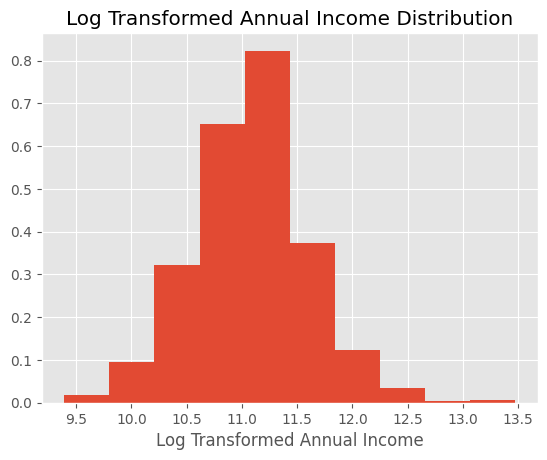

In [8]:
# Apply transformation and plot distribution
log_aincome = np.log(data.annualInc.values) # 2pts
plt.hist(log_aincome, density=True)
plt.title("Log Transformed Annual Income Distribution")
plt.xlabel("Log Transformed Annual Income")
plt.show()

# 4 pts

In [9]:
# Overwrite
data['annualInc'] = log_aincome
data.rename(columns={"annualInc": "logAnnualInc"}, inplace=True)
data.head()

# 2 pts

,loanAmnt,logAnnualInc,application_type,int_rate,revol_bal,revol_util,dti,emp_length,grade,homeOwnership,installment,job,loanDefault,mortAcc,pub_rec_bankruptcies,purpose,term,Year
0,10000.0,11.669929,INDIVIDUAL,11.44,36369.0,41.8,26.24,10,B,RENT,329.48,Marketing,0,16,0,vacation,36,2015
1,8000.0,11.082143,INDIVIDUAL,11.99,20131.0,53.3,22.05,4,B,MORTGAGE,265.68,Credit analyst,0,17,0,debt_consolidation,36,2015
2,15600.0,10.670280,INDIVIDUAL,10.49,11987.0,92.2,12.79,1,B,RENT,506.97,Statistician,0,13,0,credit_card,36,2015
3,7200.0,10.896739,INDIVIDUAL,6.49,5472.0,21.5,2.60,6,A,RENT,220.65,Client Advocate,0,6,0,credit_card,36,2014
4,24375.0,10.915088,INDIVIDUAL,17.27,24584.0,69.8,33.95,9,C,MORTGAGE,609.33,Destiny Management Inc.,1,13,0,credit_card,60,2013


#### 2.3 Plot the histograms of annual income for clients who defaulted and clients who did not default. Compare to see if there is any noticeable difference. Comment qualitatively.

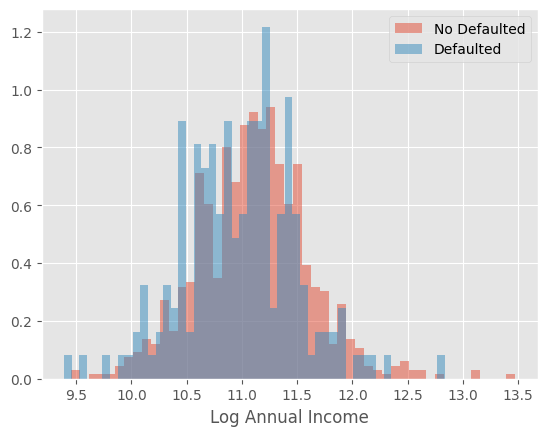

In [10]:
# Plot two distributions overlaid (use the alpha argument to create contrast in overlay plots)
data[data.loanDefault==0].logAnnualInc.hist(bins=50, density=True, alpha=0.5, label="No Defaulted")
data[data.loanDefault==1].logAnnualInc.hist(bins=50, density=True, alpha=0.5, label="Defaulted")

plt.xlabel("Log Annual Income")
plt.legend()
plt.show()

# 4 pts

**Written Answer** [2pts]:  We could see that the distributions do not show obvious differences.

___________

## Question 3: /14 pts

Let's build a model and use the annual income to predict the default outcome.

#### 3.1 Create a model pipline to include preprocessing step using `StandardScaler` and a basic logistic regression model (with default penalization and use `solver='lbfgs'`, `max_iter=10000` and `random_state=0`)

In [11]:
model = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(solver='lbfgs', max_iter=10000, random_state=0))
])
# 2 pt

#### 3.2 Use a 80/20 train-test split of the data and remember to set `random_state=0`. Fit the model and then evaluate this model plotting the ROC curve and reporting the AUC value.

In [12]:
# Get the X and y
X,y = data[['logAnnualInc']], data.loanDefault.values

# Split the train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3,random_state=0)

# Fit the model
model.fit(Xtrain, ytrain)

# 4 pts

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(max_iter=10000, random_state=0))])

Text(0.5, 1.0, 'ROC curve')

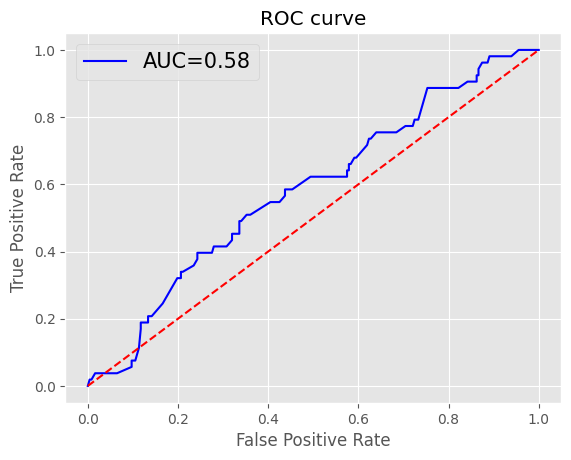

In [13]:
# Use predict_proba to get the probability of default
ytest_pred = model.predict_proba(Xtest)[:,1]

# 2 pts

# Plot the ROC curve and report AUC
fpr, tpr, _ = roc_curve(ytest, ytest_pred, pos_label=1)
auc_model = auc(fpr, tpr)

plt.plot(fpr, tpr, "b-", label="AUC={:2.2f}".format(auc_model))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve")

# 4 pts

Is income itself alone good enough to predict the default outcome?


**Written Answer** [2 pt] From the AUC value, it does not show good performance.

____________

## Question 4: /34

Here, let's use cross-validation to find how each numeric feature performs to predict the default status.


#### 4.1: Let's write our own function instead of using `cross_val_score` to get the cross-validation AUC score. First, create a function `AUC_calculation` with inputs `(model, X, y, index_train, index_test)`  which calculates the AUC of the model trained on `index_train` and tested on `index_test`. Here we assume that X and y are pandas dataframe.

In [14]:
def AUC_calculation(model, X, y, index_train, index_test):
    # Define Xtrain, ytrain, Xtest, ytest
    Xtrain, ytrain = X.iloc[index_train], y.iloc[index_train]
    Xtest, ytest = X.iloc[index_test], y.iloc[index_test]
    # Fit the model
    model_onepred = model.fit(Xtrain, ytrain)
    ytest_pred = model_onepred.predict_proba(Xtest)[:,1]
    # Calculate the auc score
    score_auc = roc_auc_score(ytest, ytest_pred)
    return score_auc
# 6 pts

#### 4.2: Create a function named `AUC_cross_validation` which has as input (model, X, y, n_fold) and does a `StratifiedKFold` cross validation with n_fold and its output should be a list with the AUC for each fold. This function will call the above function `AUC_calculation`.

In [15]:
def AUC_cross_validation(model, X, y, n_fold):
    # Create the stratified folds
    str_kf = StratifiedKFold(n_splits=n_fold)

    list_auc = []
    for index_train, index_test in str_kf.split(X,y):
        measure = AUC_calculation(model, X, y, index_train, index_test)
        list_auc.append(measure)
    return list_auc
# 6 pts

#### 4.3 Now we are ready to estimate and compare through cross validation the performance of all the *simple models* that only use one numeric predictor as input. Here we will apply logarithm transformation for the `loanAmnt` and replace it. We will also exclude `Year` and `installment`.

In [16]:
# Extract only the numeric features
feau_num = ['int32', 'int64', 'float64']
data_num = pd.DataFrame(data.select_dtypes(include=feau_num))


# Log transform
data_num['logLoanAmnt'] = np.log(data['loanAmnt'])

# Drop
data_num = data_num.drop(['Year', 'installment', 'loanAmnt'], axis=1)


data_num.head()
# 2pts

,logAnnualInc,int_rate,revol_bal,revol_util,dti,emp_length,loanDefault,mortAcc,pub_rec_bankruptcies,term,logLoanAmnt
0,11.669929,11.44,36369.0,41.8,26.24,10,0,16,0,36,9.210340
1,11.082143,11.99,20131.0,53.3,22.05,4,0,17,0,36,8.987197
2,10.670280,10.49,11987.0,92.2,12.79,1,0,13,0,36,9.655026
3,10.896739,6.49,5472.0,21.5,2.60,6,0,6,0,36,8.881836
4,10.915088,17.27,24584.0,69.8,33.95,9,1,13,0,60,10.101313


#### 4.4: Use the function `AUC_cross_validation` and the model from Q3.1 to compute cross-validation estimates of the AUC for each single numeric feature model, and use a pandas dataframe (named `AUC_models`) to store the AUC value for each fold and each of the models (use `n_fold=10`).

The column names of `AUC_models` have to be in the form `Simple-[numeric predictor variable]`, *e.g.*, `simple-int_rate`.

In [17]:
# Construct AUC_models dataframe
AUC_models = pd.DataFrame({})

# Run cross-validation for each feature
for num_pred in data_num.columns:
    if num_pred=='loanDefault':
        continue
    X, y = data_num[[num_pred]], data_num.loanDefault
    list_auc = AUC_cross_validation(model, X, y, n_fold=10)
    AUC_models['Simple-'+ num_pred] =list_auc
# 8 pts

In [18]:
# Print AUC_models dataframe. The shape should be 10 x number of features
AUC_models


,Simple-logAnnualInc,Simple-int_rate,Simple-revol_bal,Simple-revol_util,Simple-dti,Simple-emp_length,Simple-mortAcc,Simple-pub_rec_bankruptcies,Simple-term,Simple-logLoanAmnt
0,0.681077,0.723246,0.548547,0.566265,0.568746,0.498937,0.635719,0.499291,0.597449,0.430546
1,0.434282,0.797425,0.566396,0.522358,0.540650,0.649390,0.453591,0.482385,0.646341,0.623984
2,0.697154,0.610772,0.582656,0.509824,0.497967,0.441734,0.566396,0.531843,0.547425,0.442073
3,0.631098,0.651084,0.574526,0.422087,0.644648,0.519986,0.489160,0.567073,0.596883,0.562669
4,0.552168,0.522358,0.484417,0.473577,0.531165,0.561992,0.506098,0.519648,0.513550,0.440041
5,0.449864,0.745935,0.593496,0.506775,0.526762,0.533198,0.509485,0.488482,0.507453,0.523374
6,0.639566,0.765921,0.594851,0.651423,0.563686,0.539634,0.577575,0.506775,0.636856,0.524051
7,0.483401,0.761518,0.437669,0.555894,0.523035,0.430894,0.465447,0.518970,0.741870,0.629743
8,0.622290,0.607724,0.521003,0.593835,0.603659,0.561992,0.542683,0.554878,0.581301,0.461043
9,0.525745,0.441396,0.531843,0.386518,0.588753,0.599255,0.465786,0.469512,0.529133,0.485772


#### 4.5: Let's use a `sns.boxplot`` (without presenting outliers) to show the distribution of the AUC scores for each feature.

Text(0, 0.5, 'AUC')

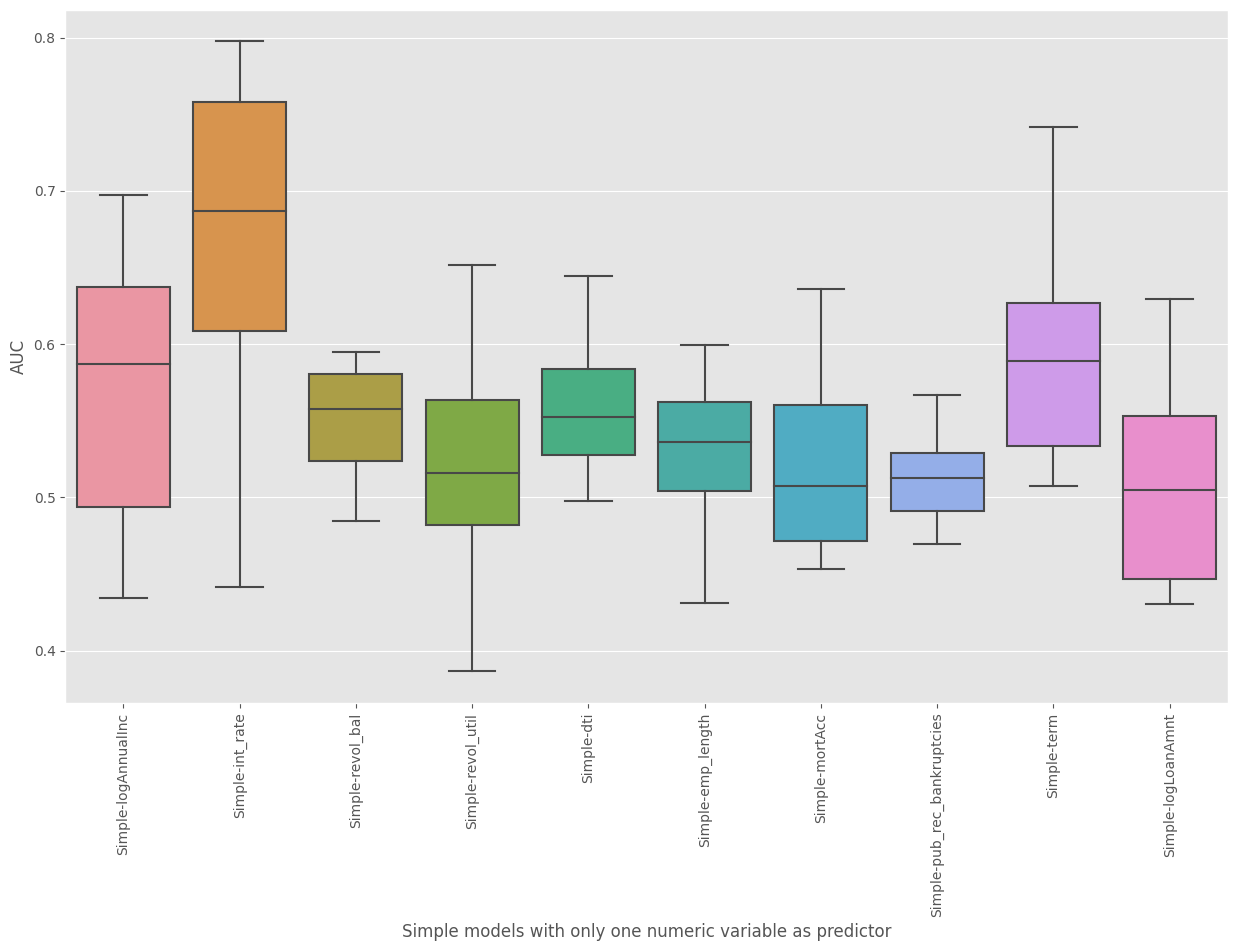

In [19]:
# Hint: use data=pd.melt(AUC_models) in boxplot
plt.figure(figsize=(15,9))
sns.boxplot(x='variable', y='value', data=pd.melt(AUC_models), showfliers=False)
plt.xticks(rotation=90)
plt.xlabel('Simple models with only one numeric variable as predictor')
plt.ylabel('AUC')
#5 pts


What is the feature that yields the best performance?

**Written Answer** [1 pt]: The int_rate.

#### 4.6: Now let's use a model including all the numeric features for training. Again use 10-fold cross-validation to determine if this new model has better performance. Add the results to the previous AUC_models dataframe and visualize again using boxplots.

In [20]:
Xall, yall = data_num.drop(['loanDefault'], axis=1), data_num.loanDefault
list_auc_all = AUC_cross_validation(model, Xall, yall, n_fold=10)
AUC_models['All_numeric']=list_auc_all
# 4 pts

# Print the new data frame
AUC_models


,Simple-logAnnualInc,Simple-int_rate,Simple-revol_bal,Simple-revol_util,Simple-dti,Simple-emp_length,Simple-mortAcc,Simple-pub_rec_bankruptcies,Simple-term,Simple-logLoanAmnt,All_numeric
0,0.681077,0.723246,0.548547,0.566265,0.568746,0.498937,0.635719,0.499291,0.597449,0.430546,0.766832
1,0.434282,0.797425,0.566396,0.522358,0.540650,0.649390,0.453591,0.482385,0.646341,0.623984,0.748645
2,0.697154,0.610772,0.582656,0.509824,0.497967,0.441734,0.566396,0.531843,0.547425,0.442073,0.647696
3,0.631098,0.651084,0.574526,0.422087,0.644648,0.519986,0.489160,0.567073,0.596883,0.562669,0.686992
4,0.552168,0.522358,0.484417,0.473577,0.531165,0.561992,0.506098,0.519648,0.513550,0.440041,0.539973
5,0.449864,0.745935,0.593496,0.506775,0.526762,0.533198,0.509485,0.488482,0.507453,0.523374,0.680894
6,0.639566,0.765921,0.594851,0.651423,0.563686,0.539634,0.577575,0.506775,0.636856,0.524051,0.752710
7,0.483401,0.761518,0.437669,0.555894,0.523035,0.430894,0.465447,0.518970,0.741870,0.629743,0.665989
8,0.622290,0.607724,0.521003,0.593835,0.603659,0.561992,0.542683,0.554878,0.581301,0.461043,0.691734
9,0.525745,0.441396,0.531843,0.386518,0.588753,0.599255,0.465786,0.469512,0.529133,0.485772,0.515583


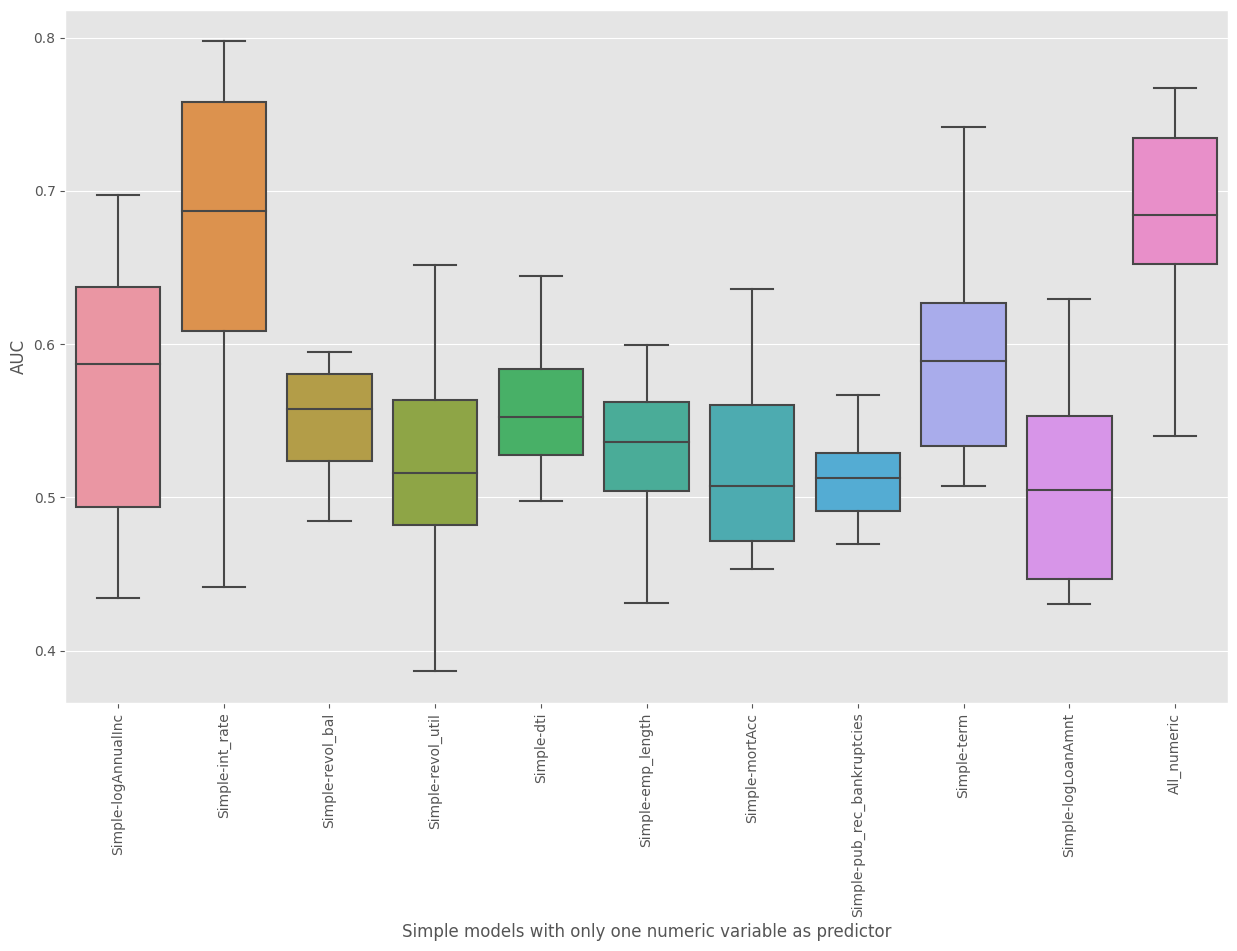

In [21]:
# Plot the histograms
plt.figure(figsize=(15,9))
sns.boxplot(x='variable', y='value', data=pd.melt(AUC_models), showfliers=False)
plt.xticks(rotation=90)
plt.xlabel('Simple models with only one numeric variable as predictor')
plt.ylabel('AUC')
plt.show()
# 2 pts

_____________

### Question 5: /10 pts

#### 5.1 Let's also include the categorical variable `grade` to the model (in addition to all the all the numeric features). And, again, add the results to the `AUC_models` dataframe.

In [22]:
data.grade.value_counts()

B    315
C    259
A    164
D    153
E     67
F     34
G      8
Name: grade, dtype: int64

In [23]:
# Convert category into numerical values
cat_grade= data.grade.replace(['A', 'B', 'C', 'D', 'E', 'F', 'G'], [1, 2, 3, 4, 5, 6, 7])

# Add this feature to all the numeric variables
Xall_grade = Xall.copy()
Xall_grade['grade'] = cat_grade

# Calculate the auc scores using cross validation
list_auc_allgrade = AUC_cross_validation(model, Xall_grade, yall, n_fold=10)

# Include the auc scores in the AUC_models DataFrame in the column 'All_numeric_&_Grade'
AUC_models['All_numeric_&_Grade'] = list_auc_allgrade

# 4 pts

#### 5.2 Print the AUC mean and AUC standard deviation for each of the models. Which model would you choose and why?

In [25]:
print(AUC_models.mean(axis=0))
print("---------------------------------------")
print(AUC_models.std(axis=0))

print(f"\nThe best is {AUC_models.mean(axis=0).sort_values().index[-1]}\n")

the_best = AUC_models[AUC_models.mean(axis=0).sort_values().index[-1]].mean() \
    - AUC_models[AUC_models.mean(axis=0).sort_values().index[-1]].std()

AUC_models.drop(AUC_models.mean(axis=0).sort_values().index[-1], axis=1).mean(axis=0) \
    +AUC_models.drop(AUC_models.mean(axis=0).sort_values().index[-1], axis=1).std() >= the_best

# 6

Simple-logAnnualInc            0.571665
Simple-int_rate                0.662738
Simple-revol_bal               0.543540
Simple-revol_util              0.518856
Simple-dti                     0.558907
Simple-emp_length              0.533701
Simple-mortAcc                 0.521194
Simple-pub_rec_bankruptcies    0.513886
Simple-term                    0.589826
Simple-logLoanAmnt             0.512330
All_numeric                    0.669705
All_numeric_&_Grade            0.680126
dtype: float64
---------------------------------------
Simple-logAnnualInc            0.095692
Simple-int_rate                0.117232
Simple-revol_bal               0.051115
Simple-revol_util              0.078869
Simple-dti                     0.044097
Simple-emp_length              0.066451
Simple-mortAcc                 0.058632
Simple-pub_rec_bankruptcies    0.031200
Simple-term                    0.072102
Simple-logLoanAmnt             0.073961
All_numeric                    0.084687
All_numeric_&_Grade      

Simple-logAnnualInc             True
Simple-int_rate                 True
Simple-revol_bal               False
Simple-revol_util               True
Simple-dti                      True
Simple-emp_length               True
Simple-mortAcc                 False
Simple-pub_rec_bankruptcies    False
Simple-term                     True
Simple-logLoanAmnt             False
All_numeric                     True
dtype: bool

**Written Answer** [2 pts]: "All_numeric_&_Grade" appears to be the best model. However, if we go strictly by what discussed in the lecture, those labeled by "True" above could be potentially good enough. It ultimately depends on the requirements of the project and computational complexity appetite. In general, the method discussed for model selection in the lab is used less often for classification problems compared to regression.

______________

### Question 6: /14pts

Train and test the model you selected using a 80/20 train-test split of the data.

- Use boostrap technique without refitting the model to obtain a confidence interval for the test AUC measure
- Plot the distribution of the boostrap AUC scores

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xall,
                                                yall,
                                                test_size=0.2,
                                                random_state=0)

#Fit the model
model.fit(Xtrain, ytrain)
#Calculate the predictions on the Test data
ytest_pred=model.predict_proba(Xtest)[:,1]

# Report the AUC of the selected model on the test set
auc_model = roc_auc_score(ytest, ytest_pred)
print(f'The AUC of the model is: {auc_model}')
# 2 pt

The AUC of the model is: 0.6470189701897019


In [ ]:
boostraps_num = 10000
boostraps_auc =[]
n = len(ytest)


np.random.RandomState(0)
for i in range(boostraps_num):
    index = np.random.randint(0, n, n)
    score = roc_auc_score(ytest.values[index],ytest_pred[index])
    boostraps_auc.append(score)
# 4 pts

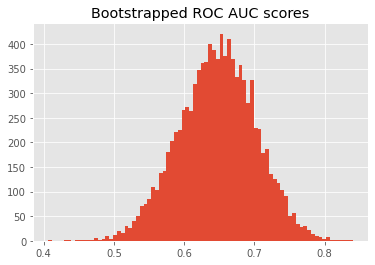

In [ ]:
plt.hist(boostraps_auc, bins=80)
plt.title('Bootstrapped ROC AUC scores')
plt.show()
# 2 pts

In [ ]:
boot_CL = 95/100

p_1 = (1-boot_CL)/2
p_2 = 1-p_1

boot_quant = np.quantile(boostraps_auc-auc_model, [p_1, p_2])

boot_ci = [(auc_model - boot_quant[1]).round(2),
           (auc_model - boot_quant[0]).round(2)]

print(f"The CI for the AUC of the model is {boot_ci}.")

####### OR

# Sort the samples
org_boots_auc= np.array(boostraps_auc)
org_boots_auc.sort()

# Calculating the limits, this is the 0.025 and 0.975 percentiles of the Boostrap distribution
ci_min = round(org_boots_auc[int(0.025*boostraps_num)],2)
ci_max = round(org_boots_auc[int(0.975*boostraps_num)],2)

print(f'The CI for the AUC of the model is {[ci_min,ci_max]}.')


# 6 pts

The CI for the AUC of the model is [0.54, 0.76].
The CI for the AUC of the model is [0.54, 0.75].
